##### Copyright 2020 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/mnist"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/mnist.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [4]:
!pip install tensorflow==2.7.0

  Obtaining dependency information for google-auth<3,>=1.6.3 from https://files.pythonhosted.org/packages/2d/9a/3d5087d27865c2f0431b942b5c4500b7d1b744dd3262fdc973a4c39d099e/google_auth-2.36.0-py2.py3-none-any.whl.metadata
  Using cached google_auth-2.36.0-py2.py3-none-any.whl.metadata (4.7 kB)
Using cached google_auth-2.36.0-py2.py3-none-any.whl (209 kB)
  Attempting uninstall: google-auth
    Found existing installation: google-auth 1.18.0
    Uninstalling google-auth-1.18.0:
      Successfully uninstalled google-auth-1.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.21.0 requires google-auth<2.0dev,>=1.18.0, but you have google-auth 2.36.0 which is incompatible.
tensorflow-quantum 0.7.2 requires google-auth==1.18.0, but you have google-auth 2.36.0 which is incompatible.
tensorflow-quantum 0.7.2 requires protobuf==3.17.3, but you have pr

Install TensorFlow Quantum:

In [5]:
!pip install tensorflow-quantum==0.7.2

  Obtaining dependency information for google-auth==1.18.0 from https://files.pythonhosted.org/packages/21/57/d706964a7e4056f3f2244e16705388c11631fbb53d3e2d2a2d0fbc24d470/google_auth-1.18.0-py2.py3-none-any.whl.metadata
  Using cached google_auth-1.18.0-py2.py3-none-any.whl.metadata (3.1 kB)
  Obtaining dependency information for protobuf==3.17.3 from https://files.pythonhosted.org/packages/e1/24/762768848490169a1a0a6843e183e5f251da12e588c7b5421f39e0e23c14/protobuf-3.17.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata
  Using cached protobuf-3.17.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (857 bytes)
Using cached google_auth-1.18.0-py2.py3-none-any.whl (90 kB)
Using cached protobuf-3.17.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: google-auth
    F

In [6]:
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/home/henrique/Documentos/quantum/.venv/lib/python3.8/site-packages/pkg_resources/__init__.py'>

Now import TensorFlow and the module dependencies:

In [8]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Cirq circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [10]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [11]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


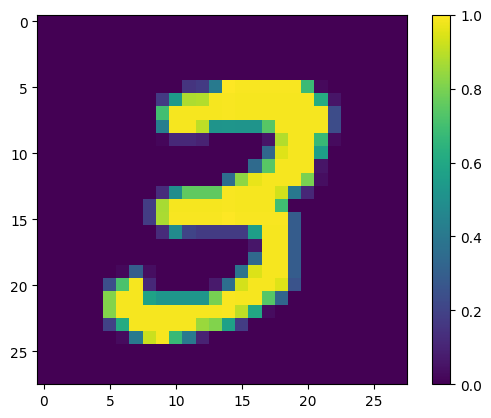

In [12]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [13]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

In [14]:
print(x_train_small.shape)

(12049, 4, 4, 1)


Again, display the first training example—after resize: 

True


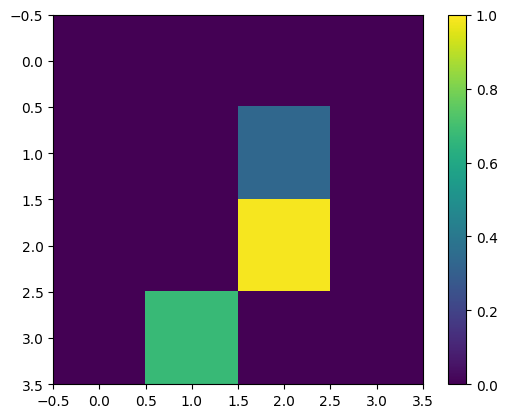

In [15]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [16]:
def remove_contradicting(xs, ys):
    return xs, ys
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [17]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [18]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

In [19]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [20]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

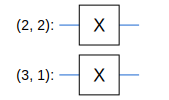

In [21]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [22]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [23]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [24]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

Build an example circuit layer to see how it looks:

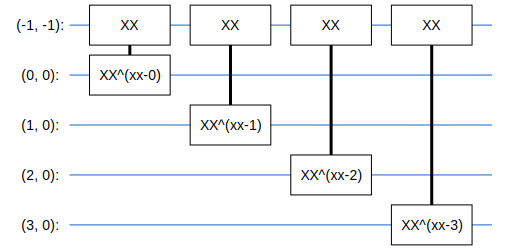

In [25]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [26]:

# Definir a grade de 16 qubits (4x4) e o qubit de leitura
data_qubits = cirq.GridQubit.rect(4, 4)
readout = cirq.GridQubit(-1, -1)

# Classe auxiliar para criar camadas no circuito
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        """Adiciona uma camada de portas em pares de qubits."""
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(f"{prefix}-{i}")
            circuit.append(gate(qubit, self.readout)**symbol)

# Função para criar o modelo convolucional quântico
def create_quantum_convolutional_model():
    circuit = cirq.Circuit()
    
    # Preparar o qubit de leitura
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    # Definir um construtor de camadas
    builder = CircuitLayerBuilder(data_qubits, readout)
    
    # Primeira camada de convolução
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Pooling para reduzir para 8 qubits (conectando pares de qubits adjacentes)
    for i in range(0, len(data_qubits), 2):
        circuit.append(cirq.CNOT(data_qubits[i], data_qubits[i + 1]))

    # Segunda camada de convolução
    builder.add_layer(circuit, cirq.XX, "xx2")
    builder.add_layer(circuit, cirq.ZZ, "zz2")

    # Pooling para reduzir para 4 qubits
    for i in range(0, len(data_qubits), 4):
        circuit.append(cirq.CNOT(data_qubits[i], data_qubits[i + 2]))

    # Terceira camada de convolução
    builder.add_layer(circuit, cirq.XX, "xx3")
    builder.add_layer(circuit, cirq.ZZ, "zz3")

    # Pooling final conectando os últimos 4 qubits ao qubit de leitura
    for i in range(0, 4):
        circuit.append(cirq.CNOT(data_qubits[i], readout))

    # Preparar o qubit de leitura para medição
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

# Criar o circuito e a operação de leitura
model_circuit, model_readout = create_quantum_convolutional_model()

# Construir o modelo Keras com o circuito convolucional quântico
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, model_readout),
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 96        
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [27]:
model_circuit, model_readout = create_quantum_convolutional_model()

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [28]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [29]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [30]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [31]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [32]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_1 (PQC)                 (None, 1)                 96        
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________
None


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [33]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [34]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set.

In [33]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
230/377 [=================>............] - ETA: 14:16 - loss: 0.7468 - hinge_accuracy: 0.7989

KeyboardInterrupt: 

Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

## 3. Teste de Filtros - MNIST

Esta é a parte original do trabalho, em que vários filtros são testados e aplicados para descobrirmos qual o melhor filtro para o problema.

> Vale notar que o filtro pode ser dependente do tipo de classificador que está sendo utilizado, neste caso estamos descobrindo qual melhor classificador para o problema baseado no modelo do artigo "Rede Neural Utilizada".

In [35]:
def process_data(x_train, x_test, y_train, y_test, method, antialias=False):
    # sobel fiter resize
    x_train_resized = tf.image.resize(x_train, (4,4), method=method, antialias=antialias).numpy()
    x_test_resized = tf.image.resize(x_test, (4,4), method=method, antialias=antialias).numpy()

    print(y_train[0])

    if len(x_train_resized.shape) == 4:
      plt.imshow(x_train_resized[0,:,:,0], vmin=0, vmax=1)
      plt.colorbar()
    else:
      plt.imshow(x_train_resized[0,:,:], vmin=0, vmax=1)

    # Retirar contraditórios - igual no artigo base e no código do Google

    # x_train_resized, y_train_resized = remove_contradicting(x_train_resized, y_train)
    x_train_resized, y_train_resized = x_train_resized, y_train

    # binarizar

    THRESHOLD = 0.5

    x_train_bin = np.array(x_train_resized > THRESHOLD, dtype=np.float32)
    x_test_bin = np.array(x_test_resized > THRESHOLD, dtype=np.float32)

    x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
    x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

    # converter para tensor

    x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
    x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

    # Otimizar Hinge Loss

    y_train_hinge = 2.0*y_train_resized-1.0
    y_test_hinge = 2.0*y_test-1.0

    # Treinar o modelo

    EPOCHS = 3
    BATCH_SIZE = 32

    NUM_EXAMPLES = len(x_train_tfcirc)

    x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
    y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

    qnn_history_resized = model.fit(
          x_train_tfcirc_sub, y_train_hinge_sub,
          batch_size=32,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_test_tfcirc, y_test_hinge))

    qnn_results_resized = model.evaluate(x_test_tfcirc, y_test)
    
    return qnn_results_resized

### 3.1 Filtro de interpolação bilinear

True
Epoch 1/3
377/377 [==============================] - 2169s 6s/step - loss: 0.3631 - hinge_accuracy: 0.8869 - val_loss: 0.3538 - val_hinge_accuracy: 0.9042
Epoch 2/3
377/377 [==============================] - 2115s 6s/step - loss: 0.3604 - hinge_accuracy: 0.8913 - val_loss: 0.3469 - val_hinge_accuracy: 0.9042
Epoch 3/3
62/62 [==============================] - 49s 793ms/step - loss: 0.3447 - hinge_accuracy: 0.8992


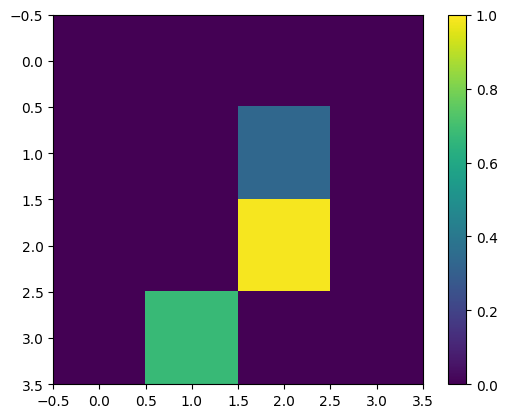

In [69]:
qnn_results_bilinear = process_data(x_train, x_test, y_train, y_test, 'bilinear')

### 3.2 Filtro de Hat/Tent

True
Epoch 1/3
377/377 [==============================] - 2194s 6s/step - loss: 0.6907 - hinge_accuracy: 0.6768 - val_loss: 0.6192 - val_hinge_accuracy: 0.7263
Epoch 2/3
377/377 [==============================] - 2121s 6s/step - loss: 0.6218 - hinge_accuracy: 0.6987 - val_loss: 0.5439 - val_hinge_accuracy: 0.7268
Epoch 3/3
62/62 [==============================] - 51s 817ms/step - loss: 0.5432 - hinge_accuracy: 0.7268


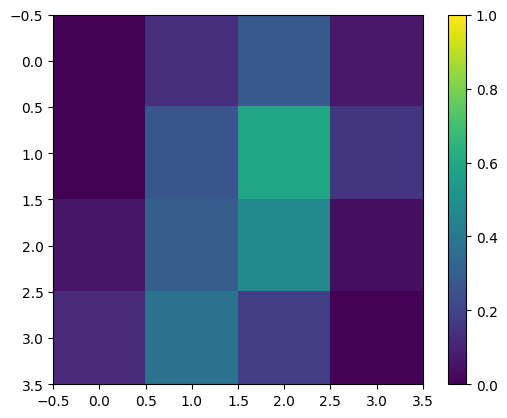

In [70]:
qnn_results_hat_tent = process_data(x_train, x_test, y_train, y_test, 'bilinear', True)

## Filtro lanczos3

True
Epoch 1/3
377/377 [==============================] - 2129s 6s/step - loss: 0.3507 - hinge_accuracy: 0.8347 - val_loss: 0.2744 - val_hinge_accuracy: 0.8664
Epoch 2/3
377/377 [==============================] - 2203s 6s/step - loss: 0.2713 - hinge_accuracy: 0.8655 - val_loss: 0.2641 - val_hinge_accuracy: 0.8775
Epoch 3/3
62/62 [==============================] - 51s 826ms/step - loss: 0.2616 - hinge_accuracy: 0.8684


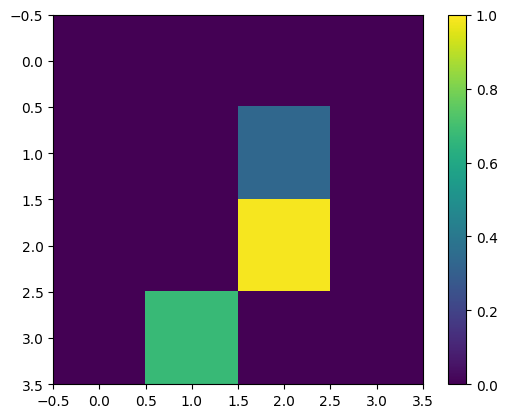

In [71]:
# sobel fiter resize
x_train_lanczos3 = tf.image.resize(x_train, (4,4), method='lanczos3').numpy()
x_test_lanczos3 = tf.image.resize(x_test, (4,4), method='lanczos3').numpy()

print(y_train[0])

plt.imshow(x_train_lanczos3[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_lanczos3, y_train_lanczos3 = remove_contradicting(x_train_lanczos3, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_lanczos3 > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_lanczos3 > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_lanczos3-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_lanczos3 = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_lanczos3 = model.evaluate(x_test_tfcirc, y_test)

### Filtro lanczos5

True


Epoch 1/3
377/377 [==============================] - 2130s 6s/step - loss: 0.2594 - hinge_accuracy: 0.8716 - val_loss: 0.2617 - val_hinge_accuracy: 0.8684
Epoch 2/3
377/377 [==============================] - 2163s 6s/step - loss: 0.2578 - hinge_accuracy: 0.8716 - val_loss: 0.2620 - val_hinge_accuracy: 0.8684
Epoch 3/3
62/62 [==============================] - 43s 689ms/step - loss: 0.2619 - hinge_accuracy: 0.8700


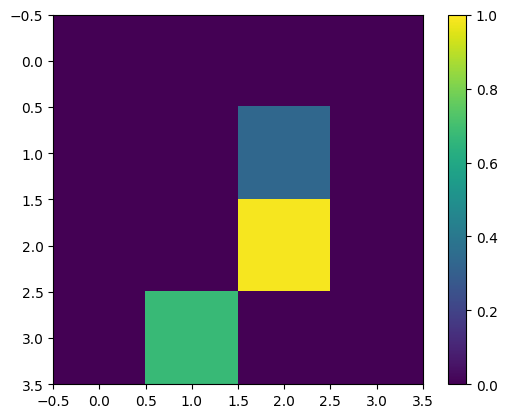

In [72]:
# sobel fiter resize
x_train_lanczos5 = tf.image.resize(x_train, (4,4), method='lanczos5').numpy()
x_test_lanczos5 = tf.image.resize(x_test, (4,4), method='lanczos5').numpy()

print(y_train[0])

plt.imshow(x_train_lanczos5[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_lanczos5, y_train_lanczos5 = remove_contradicting(x_train_lanczos5, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_lanczos5 > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_lanczos5 > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_lanczos5-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_lanczos5 = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_lanczos5 = model.evaluate(x_test_tfcirc, y_test)

### Filtro bicubic

True
Epoch 1/3
377/377 [==============================] - 2193s 6s/step - loss: 0.2563 - hinge_accuracy: 0.8736 - val_loss: 0.2625 - val_hinge_accuracy: 0.8705
Epoch 2/3
377/377 [==============================] - 2025s 5s/step - loss: 0.2558 - hinge_accuracy: 0.8735 - val_loss: 0.2614 - val_hinge_accuracy: 0.8705
Epoch 3/3
62/62 [==============================] - 54s 872ms/step - loss: 0.2615 - hinge_accuracy: 0.8700


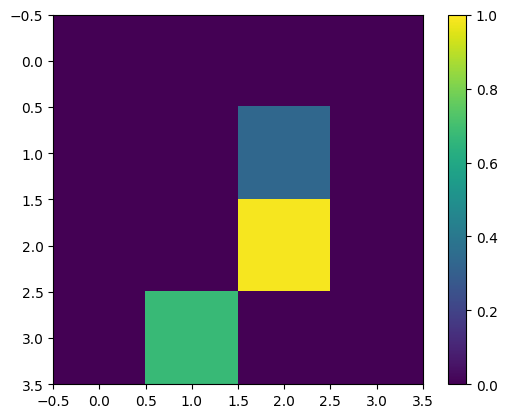

In [73]:
# sobel fiter resize
x_train_bicubic = tf.image.resize(x_train, (4,4), method='bicubic').numpy()
x_test_bicubic = tf.image.resize(x_test, (4,4), method='bicubic').numpy()

print(y_train[0])

plt.imshow(x_train_bicubic[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_bicubic, y_train_bicubic = remove_contradicting(x_train_bicubic, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_bicubic > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_bicubic > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_bicubic-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_bicubic = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_bicubic = model.evaluate(x_test_tfcirc, y_test)

### Filtro gaussian

True
Epoch 1/3
377/377 [==============================] - 2010s 5s/step - loss: 0.2480 - hinge_accuracy: 0.8775 - val_loss: 0.2529 - val_hinge_accuracy: 0.8740
Epoch 2/3
377/377 [==============================] - 2182s 6s/step - loss: 0.2475 - hinge_accuracy: 0.8776 - val_loss: 0.2529 - val_hinge_accuracy: 0.8755
Epoch 3/3
62/62 [==============================] - 51s 819ms/step - loss: 0.2534 - hinge_accuracy: 0.8755


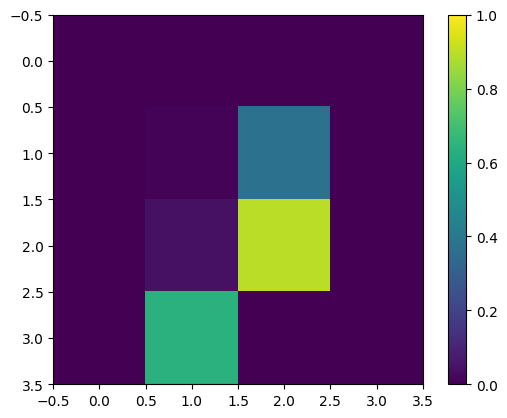

In [74]:
# sobel fiter resize
x_train_gaussian = tf.image.resize(x_train, (4,4), method='gaussian').numpy()
x_test_gaussian = tf.image.resize(x_test, (4,4), method='gaussian').numpy()

print(y_train[0])

plt.imshow(x_train_gaussian[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_gaussian, y_train_gaussian = remove_contradicting(x_train_gaussian, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_gaussian > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_gaussian > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_gaussian-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_gaussian = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_gaussian = model.evaluate(x_test_tfcirc, y_test)

### Filtro nearest

True
Epoch 1/3
377/377 [==============================] - 2083s 6s/step - loss: 0.2535 - hinge_accuracy: 0.8758 - val_loss: 0.2613 - val_hinge_accuracy: 0.8700
Epoch 2/3
377/377 [==============================] - 1984s 5s/step - loss: 0.2531 - hinge_accuracy: 0.8771 - val_loss: 0.2613 - val_hinge_accuracy: 0.8715
Epoch 3/3
62/62 [==============================] - 52s 830ms/step - loss: 0.2615 - hinge_accuracy: 0.8715


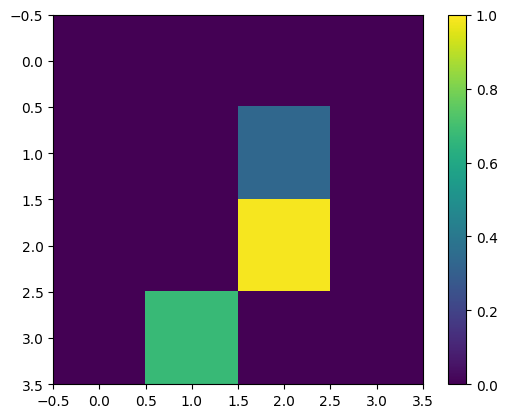

In [75]:
# sobel fiter resize
x_train_nearest = tf.image.resize(x_train, (4,4), method='nearest').numpy()
x_test_nearest = tf.image.resize(x_test, (4,4), method='nearest').numpy()

print(y_train[0])

plt.imshow(x_train_nearest[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_nearest, y_train_nearest = remove_contradicting(x_train_nearest, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_nearest > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_nearest > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_nearest-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_nearest = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_nearest = model.evaluate(x_test_tfcirc, y_test)

### Filtro area

True
Epoch 1/3
377/377 [==============================] - 2081s 6s/step - loss: 0.4026 - hinge_accuracy: 0.8060 - val_loss: 0.3220 - val_hinge_accuracy: 0.8417
Epoch 2/3
377/377 [==============================] - 2117s 6s/step - loss: 0.3654 - hinge_accuracy: 0.8191 - val_loss: 0.3197 - val_hinge_accuracy: 0.8417
Epoch 3/3
62/62 [==============================] - 51s 832ms/step - loss: 0.3193 - hinge_accuracy: 0.8412


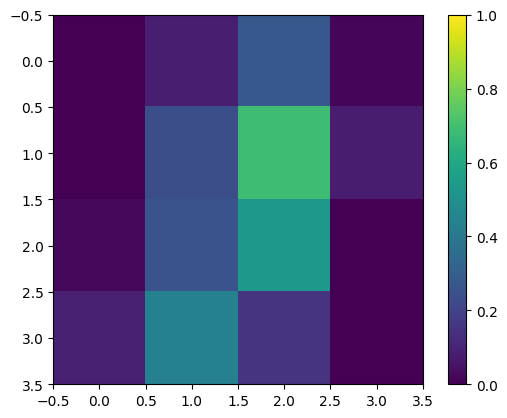

In [76]:
# sobel fiter resize
x_train_area = tf.image.resize(x_train, (4,4), method='area').numpy()
x_test_area = tf.image.resize(x_test, (4,4), method='area').numpy()

print(y_train[0])

plt.imshow(x_train_area[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_area, y_train_area = remove_contradicting(x_train_area, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_area > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_area > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_area-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_area = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_area = model.evaluate(x_test_tfcirc, y_test)

### Filtro mitchellcubic

True
Epoch 1/3
377/377 [==============================] - 2029s 5s/step - loss: 0.2726 - hinge_accuracy: 0.8699 - val_loss: 0.2564 - val_hinge_accuracy: 0.8725
Epoch 2/3
377/377 [==============================] - 2094s 6s/step - loss: 0.2511 - hinge_accuracy: 0.8744 - val_loss: 0.2555 - val_hinge_accuracy: 0.8735
Epoch 3/3
62/62 [==============================] - 51s 831ms/step - loss: 0.2572 - hinge_accuracy: 0.8775


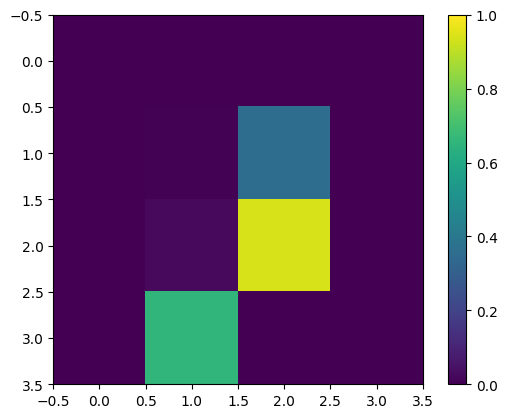

In [77]:
# sobel fiter resize
x_train_mitchellcubic = tf.image.resize(x_train, (4,4), method='mitchellcubic').numpy()
x_test_mitchellcubic = tf.image.resize(x_test, (4,4), method='mitchellcubic').numpy()

print(y_train[0])

plt.imshow(x_train_mitchellcubic[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# Retirar contraditórios - igual no artigo base e no código do Google

x_train_mitchellcubic, y_train_mitchellcubic = remove_contradicting(x_train_mitchellcubic, y_train)

# binarizar

THRESHOLD = 0.5

x_train_bin = np.array(x_train_mitchellcubic > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_mitchellcubic > THRESHOLD, dtype=np.float32)

x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

# converter para tensor

x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Otimizar Hinge Loss

y_train_hinge = 2.0*y_train_mitchellcubic-1.0
y_test_hinge = 2.0*y_test-1.0

# Treinar o modelo

EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

qnn_history_mitchellcubic = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results_mitchellcubic = model.evaluate(x_test_tfcirc, y_test)

## Comparação dos filtros

/tmp/ipykernel_6906/1215795459.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


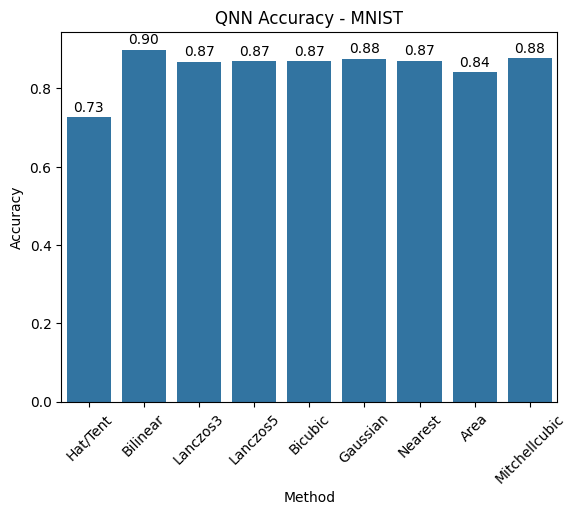

In [78]:
qnn_accuracy_hat_tent = qnn_results_hat_tent[1]
qnn_accuracy_bilinear = qnn_results_bilinear[1]
qnn_accuracy_lanczos3 = qnn_results_lanczos3[1]
qnn_accuracy_lanczos5 = qnn_results_lanczos5[1]
qnn_accuracy_bicubic = qnn_results_bicubic[1]
qnn_accuracy_gaussian = qnn_results_gaussian[1]
qnn_accuracy_nearest = qnn_results_nearest[1]
qnn_accuracy_area = qnn_results_area[1]
qnn_accuracy_mitchellcubic = qnn_results_mitchellcubic[1]


ax = sns.barplot(x=["Hat/Tent", "Bilinear", "Lanczos3", "Lanczos5", "Bicubic", "Gaussian", "Nearest", "Area", "Mitchellcubic"],
                 y=[qnn_accuracy_hat_tent, qnn_accuracy_bilinear, qnn_accuracy_lanczos3, qnn_accuracy_lanczos5, qnn_accuracy_bicubic, qnn_accuracy_gaussian, qnn_accuracy_nearest, qnn_accuracy_area, qnn_accuracy_mitchellcubic])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('QNN Accuracy - MNIST')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Method')
# Imprima a acurácia acima de cada barra
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 7),
                textcoords = 'offset points')
plt.show()


# Comparação de Filtros - CIFAR-10

2024-11-10 15:17:28.572398: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 153600000 exceeds 10% of free system memory.
2024-11-10 15:17:28.903447: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2024-11-10 15:17:29.068285: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2024-11-10 15:17:29.829486: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 204800000 exceeds 10% of free system memory.
2024-11-10 15:17:31.365001: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 204800000 exceeds 10% of free system memory.


Number of original training examples: 50000
Number of original test examples: 10000
Shape of x_train: (10000, 32, 32, 1)


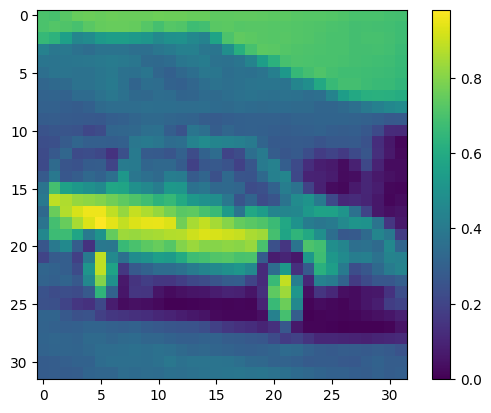

In [79]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = tf.image.rgb_to_grayscale(x_train).numpy()
x_test = tf.image.rgb_to_grayscale(x_test).numpy()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

class1 = 0  # Classe desejada 1
class2 = 1  # Classe desejada 2

# Filtrar os dados de treinamento
x_train = x_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]
y_train = y_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]

# Filtrar os dados de teste
x_test = x_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]
y_test = y_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]

# Normalizar as imagens para o intervalo [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# plot um exemplo
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

print("Shape of x_train:", x_train.shape)

## Filtro de interpolação bilinear

[1]


Epoch 1/3
313/313 [==============================] - 1719s 5s/step - loss: 0.9262 - hinge_accuracy: 0.5419 - val_loss: 0.8918 - val_hinge_accuracy: 0.5481
Epoch 2/3
313/313 [==============================] - 1743s 6s/step - loss: 0.8671 - hinge_accuracy: 0.5741 - val_loss: 0.8452 - val_hinge_accuracy: 0.5898
Epoch 3/3
63/63 [==============================] - 43s 683ms/step - loss: 0.8113 - hinge_accuracy: 0.6081


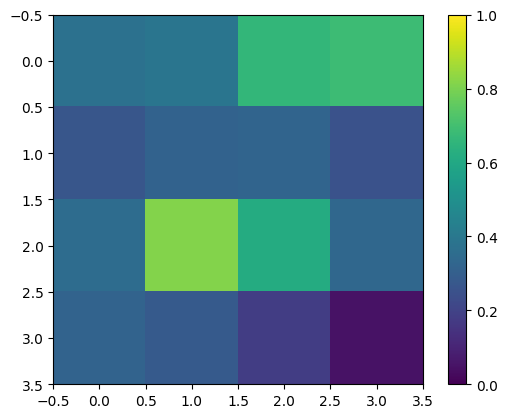

In [80]:
qnn_results_bilinear_cifar = process_data(x_train, x_test, y_train, y_test, 'bilinear')

## Filtro Hat Tent

[1]
Epoch 1/3
313/313 [==============================] - 1719s 5s/step - loss: 0.8003 - hinge_accuracy: 0.6135 - val_loss: 0.7568 - val_hinge_accuracy: 0.6448
Epoch 2/3
313/313 [==============================] - 1866s 6s/step - loss: 0.7739 - hinge_accuracy: 0.6363 - val_loss: 0.7423 - val_hinge_accuracy: 0.6508
Epoch 3/3
63/63 [==============================] - 56s 880ms/step - loss: 0.7351 - hinge_accuracy: 0.6587


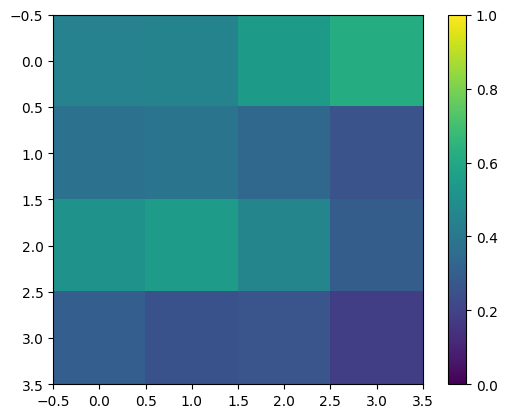

In [81]:
qnn_results_hat_tent_cifar = process_data(x_train, x_test, y_train, y_test, 'bilinear', True)

## Filtro lanczos3

[1]
Epoch 1/3
313/313 [==============================] - 1705s 5s/step - loss: 0.8022 - hinge_accuracy: 0.6209 - val_loss: 0.7688 - val_hinge_accuracy: 0.6518
Epoch 2/3
313/313 [==============================] - 1854s 6s/step - loss: 0.7909 - hinge_accuracy: 0.6265 - val_loss: 0.7637 - val_hinge_accuracy: 0.6538
Epoch 3/3
63/63 [==============================] - 54s 849ms/step - loss: 0.7521 - hinge_accuracy: 0.6567


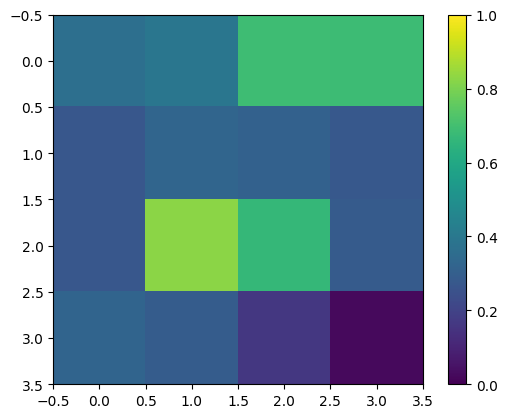

In [82]:
qnn_results_lanczos3_cifar = process_data(x_train, x_test, y_train, y_test, 'lanczos3')

## Filtro lanczos5

[1]


Epoch 1/3
313/313 [==============================] - 1711s 5s/step - loss: 0.7493 - hinge_accuracy: 0.6494 - val_loss: 0.7011 - val_hinge_accuracy: 0.6667
Epoch 2/3
313/313 [==============================] - 1885s 6s/step - loss: 0.7022 - hinge_accuracy: 0.6623 - val_loss: 0.6825 - val_hinge_accuracy: 0.6657
Epoch 3/3
63/63 [==============================] - 43s 677ms/step - loss: 0.6810 - hinge_accuracy: 0.6741


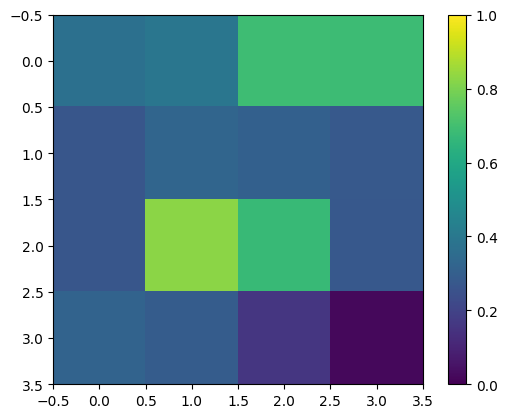

In [83]:
qnn_results_lanczos5_cifar = process_data(x_train, x_test, y_train, y_test, 'lanczos5')

## Filtro bicubic

[1]
Epoch 1/3
313/313 [==============================] - 1433s 5s/step - loss: 0.6897 - hinge_accuracy: 0.6660 - val_loss: 0.6707 - val_hinge_accuracy: 0.6781
Epoch 2/3
313/313 [==============================] - 967s 3s/step - loss: 0.6890 - hinge_accuracy: 0.6689 - val_loss: 0.6697 - val_hinge_accuracy: 0.6756
Epoch 3/3
63/63 [==============================] - 11s 174ms/step - loss: 0.6688 - hinge_accuracy: 0.6786


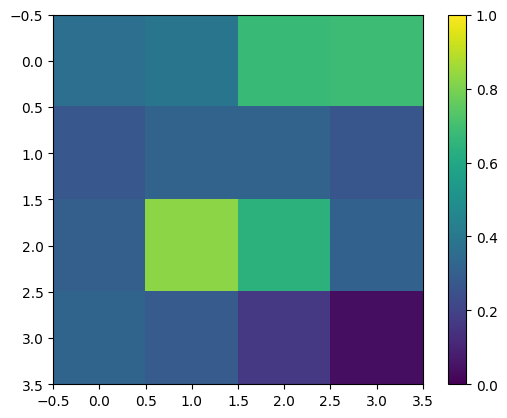

In [84]:
qnn_results_bicubic_cifar = process_data(x_train, x_test, y_train, y_test, 'bicubic')

## Filtro gaussian

[1]
Epoch 1/3
313/313 [==============================] - 976s 3s/step - loss: 0.6867 - hinge_accuracy: 0.6655 - val_loss: 0.6644 - val_hinge_accuracy: 0.6781
Epoch 2/3
313/313 [==============================] - 973s 3s/step - loss: 0.6863 - hinge_accuracy: 0.6626 - val_loss: 0.6644 - val_hinge_accuracy: 0.6756
Epoch 3/3
63/63 [==============================] - 12s 187ms/step - loss: 0.6667 - hinge_accuracy: 0.6731


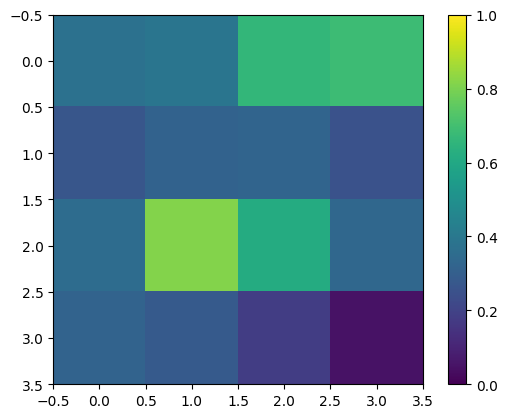

In [85]:
qnn_results_gaussian_cifar = process_data(x_train, x_test, y_train, y_test, 'gaussian')

## FIltro nearest

[1]
Epoch 1/3
313/313 [==============================] - 977s 3s/step - loss: 0.6960 - hinge_accuracy: 0.6599 - val_loss: 0.6777 - val_hinge_accuracy: 0.6716
Epoch 2/3
313/313 [==============================] - 978s 3s/step - loss: 0.6948 - hinge_accuracy: 0.6620 - val_loss: 0.6779 - val_hinge_accuracy: 0.6711
Epoch 3/3
63/63 [==============================] - 12s 190ms/step - loss: 0.6773 - hinge_accuracy: 0.6701


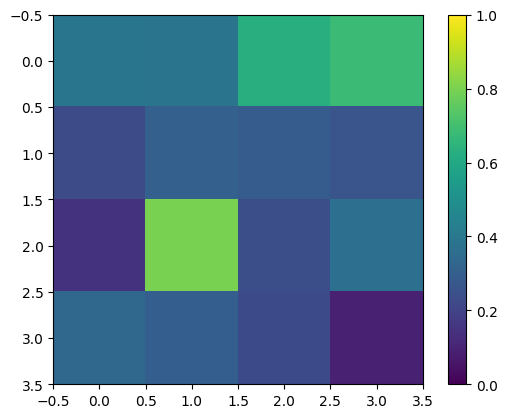

In [86]:
qnn_results_nearest_cifar = process_data(x_train, x_test, y_train, y_test, 'nearest')

## Filtro area

[1]
Epoch 1/3
313/313 [==============================] - 978s 3s/step - loss: 0.6777 - hinge_accuracy: 0.6665 - val_loss: 0.6547 - val_hinge_accuracy: 0.6756
Epoch 2/3
313/313 [==============================] - 978s 3s/step - loss: 0.6749 - hinge_accuracy: 0.6669 - val_loss: 0.6542 - val_hinge_accuracy: 0.6791
Epoch 3/3
63/63 [==============================] - 12s 185ms/step - loss: 0.6566 - hinge_accuracy: 0.6840


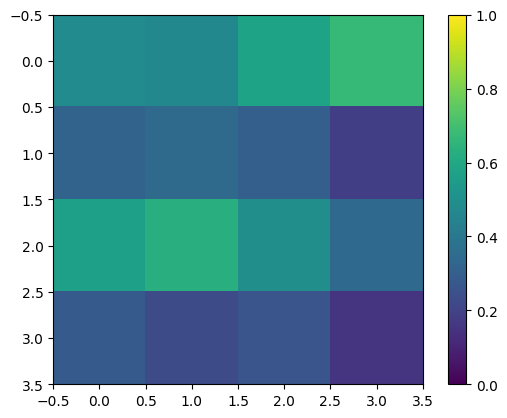

In [87]:
qnn_results_area_cifar = process_data(x_train, x_test, y_train, y_test, 'area')

## Fuiltro mitchellcubic

[1]
Epoch 1/3
313/313 [==============================] - 977s 3s/step - loss: 0.6897 - hinge_accuracy: 0.6691 - val_loss: 0.6694 - val_hinge_accuracy: 0.6746
Epoch 2/3
313/313 [==============================] - 977s 3s/step - loss: 0.6883 - hinge_accuracy: 0.6665 - val_loss: 0.6678 - val_hinge_accuracy: 0.6736
Epoch 3/3
63/63 [==============================] - 12s 185ms/step - loss: 0.6688 - hinge_accuracy: 0.6711


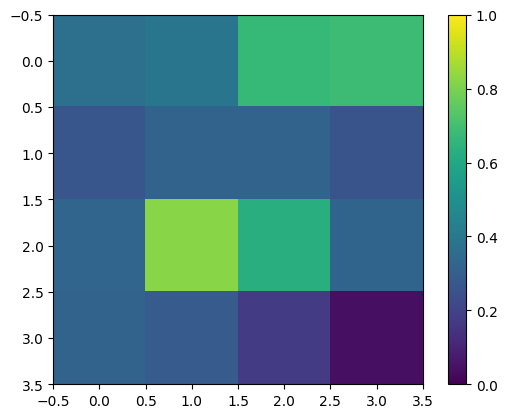

In [88]:
qnn_results_mitchellcubic_cifar = process_data(x_train, x_test, y_train, y_test, 'mitchellcubic')

## Comparação dos filtros

/tmp/ipykernel_6906/1064917995.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


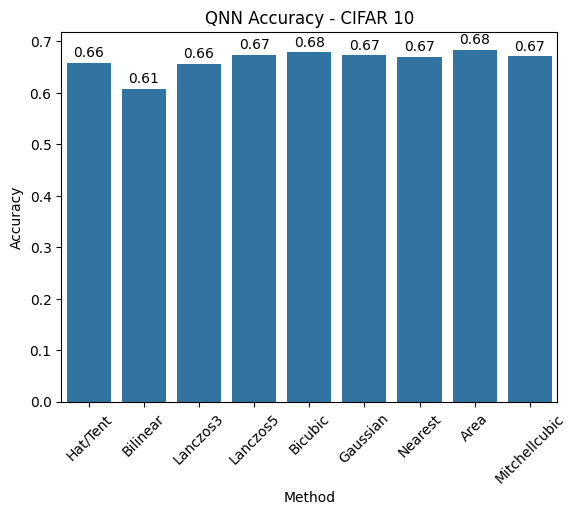

In [89]:
qnn_accuracy_hat_tent = qnn_results_hat_tent_cifar[1]
qnn_accuracy_bilinear = qnn_results_bilinear_cifar[1]
qnn_accuracy_lanczos3 = qnn_results_lanczos3_cifar[1]
qnn_accuracy_lanczos5 = qnn_results_lanczos5_cifar[1]
qnn_accuracy_bicubic = qnn_results_bicubic_cifar[1]
qnn_accuracy_gaussian = qnn_results_gaussian_cifar[1]
qnn_accuracy_nearest = qnn_results_nearest_cifar[1]
qnn_accuracy_area = qnn_results_area_cifar[1]
qnn_accuracy_mitchellcubic = qnn_results_mitchellcubic_cifar[1]

ax = sns.barplot(x=["Hat/Tent", "Bilinear", "Lanczos3", "Lanczos5", "Bicubic", "Gaussian", "Nearest", "Area", "Mitchellcubic"],
            y=[qnn_accuracy_hat_tent, qnn_accuracy_bilinear, qnn_accuracy_lanczos3, qnn_accuracy_lanczos5, qnn_accuracy_bicubic, qnn_accuracy_gaussian, qnn_accuracy_nearest, qnn_accuracy_area, qnn_accuracy_mitchellcubic])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('QNN Accuracy - CIFAR 10')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Method')
# Imprima a acurácia acima de cada barra
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 7),
                textcoords = 'offset points')
plt.show()

# Comparação Filtros Fashion MNIST

Number of original training examples: 60000
Number of original test examples: 10000


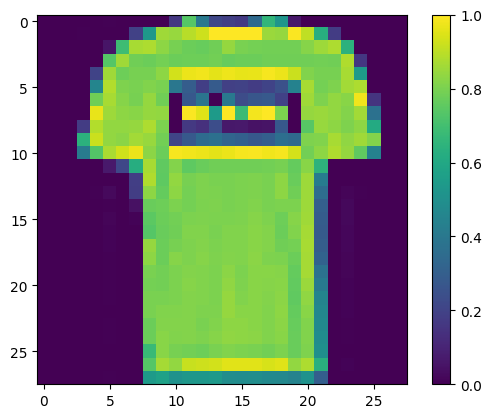

In [90]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

class1 = 0  # Classe desejada 1
class2 = 1  # Classe desejada 2

class1 = 0  # Desired class 1
class2 = 1  # Desired class 2

# Define the desired classes for filtering
classes_desejadas = [class1, class2]

# Filter the training set
train_indices = np.where(np.isin(y_train, classes_desejadas))
x_train_filtered = x_train[train_indices]
y_train_filtered = y_train[train_indices]

# Filter the test set
test_indices = np.where(np.isin(y_test, classes_desejadas))
x_test_filtered = x_test[test_indices]
y_test_filtered = y_test[test_indices]

# Normalizar as imagens para o intervalo [0, 1]
x_train_filtered = x_train_filtered / 255.0
x_test_filtered = x_test_filtered / 255.0

# plot um exemplo
plt.imshow(x_train_filtered[0, :, :])
plt.colorbar()

## Filtro Bilinear

0
Epoch 1/3
375/375 [==============================] - 1166s 3s/step - loss: 0.6696 - hinge_accuracy: 0.6934 - val_loss: 0.6633 - val_hinge_accuracy: 0.6875
Epoch 2/3
375/375 [==============================] - 1165s 3s/step - loss: 0.5982 - hinge_accuracy: 0.7184 - val_loss: 0.6251 - val_hinge_accuracy: 0.6989
Epoch 3/3
63/63 [==============================] - 12s 185ms/step - loss: 0.6183 - hinge_accuracy: 0.6979


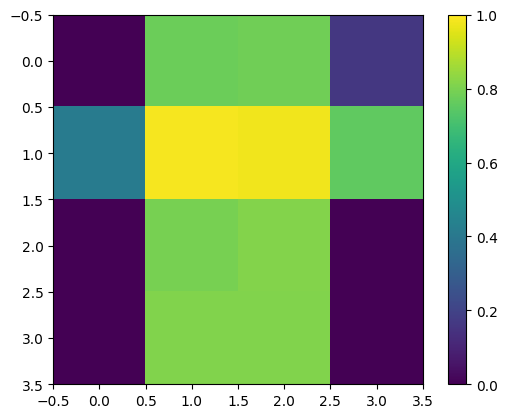

In [91]:
# resize the images
x_train_expanded = tf.expand_dims(x_train_filtered, axis=-1)
x_test_expanded = tf.expand_dims(x_test_filtered, axis=-1)

qnn_results_bilinear_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'bilinear')

# Filtro Hat/Tent

0
Epoch 1/3
375/375 [==============================] - 1157s 3s/step - loss: 0.5863 - hinge_accuracy: 0.7266 - val_loss: 0.4804 - val_hinge_accuracy: 0.7644
Epoch 2/3
375/375 [==============================] - 1159s 3s/step - loss: 0.4812 - hinge_accuracy: 0.7627 - val_loss: 0.4620 - val_hinge_accuracy: 0.7664
Epoch 3/3
63/63 [==============================] - 12s 184ms/step - loss: 0.4423 - hinge_accuracy: 0.7822


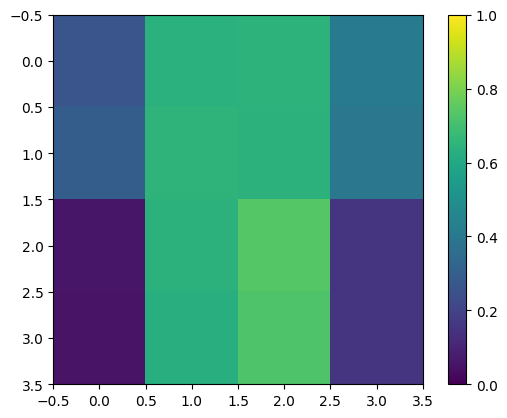

In [92]:
qnn_results_hat_tent_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'bilinear', True)

## Filtro lanczos3

0
Epoch 1/3
375/375 [==============================] - 1165s 3s/step - loss: 0.7209 - hinge_accuracy: 0.6817 - val_loss: 0.6804 - val_hinge_accuracy: 0.6855
Epoch 2/3
375/375 [==============================] - 1165s 3s/step - loss: 0.6498 - hinge_accuracy: 0.7004 - val_loss: 0.6715 - val_hinge_accuracy: 0.6855
Epoch 3/3
63/63 [==============================] - 12s 185ms/step - loss: 0.6622 - hinge_accuracy: 0.6801


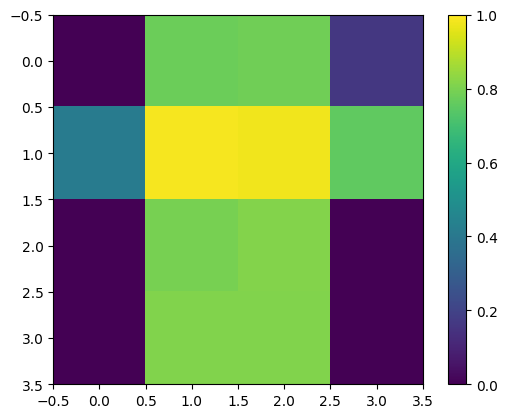

In [93]:
qnn_results_lanczos3_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'lanczos3')

## FIltro lanczos5

0
Epoch 1/3
375/375 [==============================] - 1165s 3s/step - loss: 0.6187 - hinge_accuracy: 0.7064 - val_loss: 0.6407 - val_hinge_accuracy: 0.6830
Epoch 2/3
375/375 [==============================] - 1164s 3s/step - loss: 0.5989 - hinge_accuracy: 0.7089 - val_loss: 0.6377 - val_hinge_accuracy: 0.6865
Epoch 3/3
63/63 [==============================] - 12s 187ms/step - loss: 0.6304 - hinge_accuracy: 0.6910


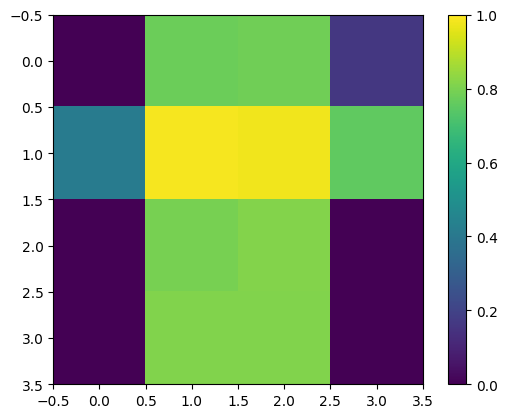

In [94]:
qnn_results_lanczos5_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'lanczos5')

## Filtro bicubic

0
Epoch 1/3
375/375 [==============================] - 1164s 3s/step - loss: 0.5757 - hinge_accuracy: 0.7189 - val_loss: 0.6201 - val_hinge_accuracy: 0.6944
Epoch 2/3
375/375 [==============================] - 1163s 3s/step - loss: 0.5698 - hinge_accuracy: 0.7201 - val_loss: 0.6147 - val_hinge_accuracy: 0.6969
Epoch 3/3
63/63 [==============================] - 12s 198ms/step - loss: 0.6124 - hinge_accuracy: 0.6959


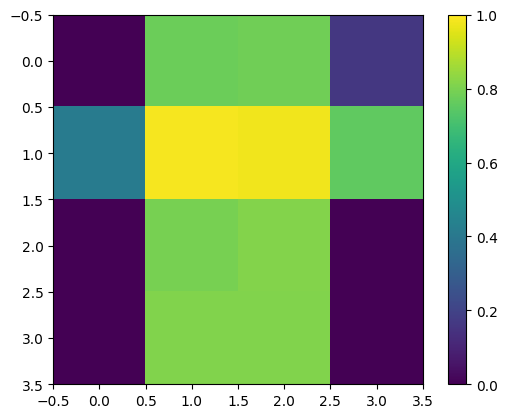

In [95]:
qnn_results_bicubic_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'bicubic')

## Filtro gaussian

0
Epoch 1/3
375/375 [==============================] - 1164s 3s/step - loss: 0.5836 - hinge_accuracy: 0.7099 - val_loss: 0.6361 - val_hinge_accuracy: 0.6820
Epoch 2/3
375/375 [==============================] - 1165s 3s/step - loss: 0.5827 - hinge_accuracy: 0.7098 - val_loss: 0.6362 - val_hinge_accuracy: 0.6815
Epoch 3/3
63/63 [==============================] - 12s 189ms/step - loss: 0.6359 - hinge_accuracy: 0.6820


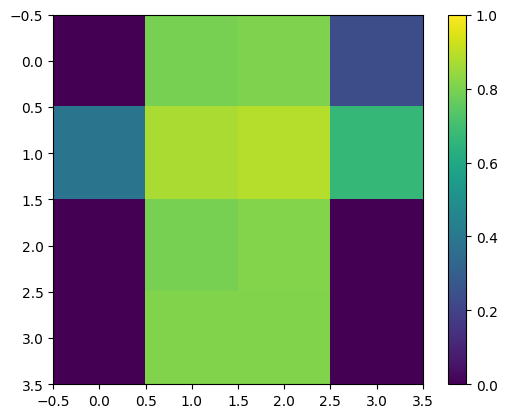

In [96]:
qnn_results_gaussian_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'gaussian')

## Filtro nearest

0
Epoch 1/3
375/375 [==============================] - 1169s 3s/step - loss: 0.5640 - hinge_accuracy: 0.7190 - val_loss: 0.6111 - val_hinge_accuracy: 0.6949
Epoch 2/3
375/375 [==============================] - 1171s 3s/step - loss: 0.5639 - hinge_accuracy: 0.7188 - val_loss: 0.6116 - val_hinge_accuracy: 0.6949
Epoch 3/3
63/63 [==============================] - 12s 191ms/step - loss: 0.6115 - hinge_accuracy: 0.6949


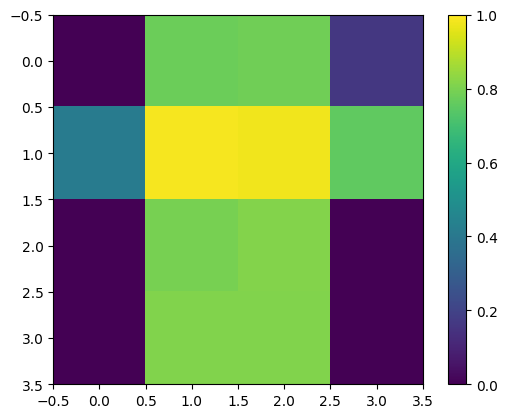

In [97]:
qnn_results_nearest_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'nearest')

## Filtro area

0
Epoch 1/3
375/375 [==============================] - 1158s 3s/step - loss: 0.5357 - hinge_accuracy: 0.7434 - val_loss: 0.4311 - val_hinge_accuracy: 0.7961
Epoch 2/3
375/375 [==============================] - 1158s 3s/step - loss: 0.4328 - hinge_accuracy: 0.7865 - val_loss: 0.4116 - val_hinge_accuracy: 0.7971
Epoch 3/3
63/63 [==============================] - 12s 182ms/step - loss: 0.4076 - hinge_accuracy: 0.7996


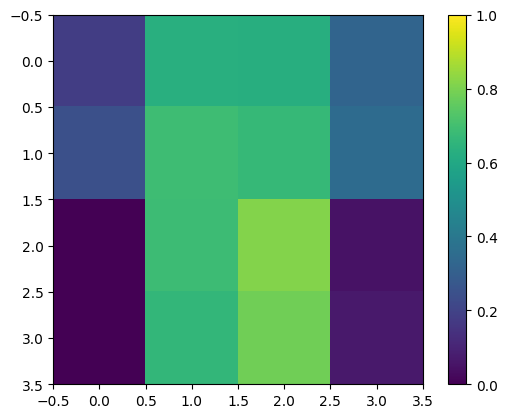

In [98]:
qnn_results_area_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'area')

## Filtro mitchellcubic

0
Epoch 1/3
375/375 [==============================] - 1164s 3s/step - loss: 0.6997 - hinge_accuracy: 0.6765 - val_loss: 0.6600 - val_hinge_accuracy: 0.6870
Epoch 2/3
375/375 [==============================] - 1164s 3s/step - loss: 0.5930 - hinge_accuracy: 0.7101 - val_loss: 0.6437 - val_hinge_accuracy: 0.6806
Epoch 3/3
63/63 [==============================] - 12s 184ms/step - loss: 0.6403 - hinge_accuracy: 0.6796


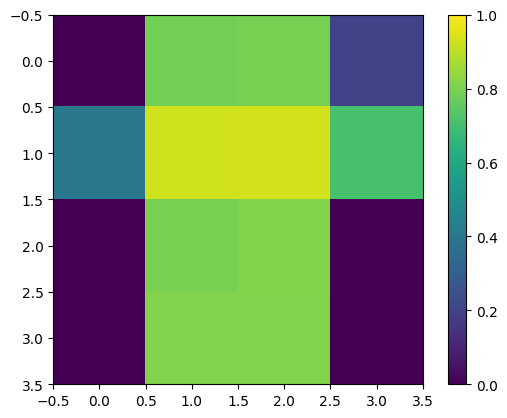

In [99]:
qnn_results_mitchellcubic_fashion = process_data(x_train_expanded, x_test_expanded, y_train_filtered, y_test_filtered, 'mitchellcubic')

## Comparação

/tmp/ipykernel_6906/3180368054.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


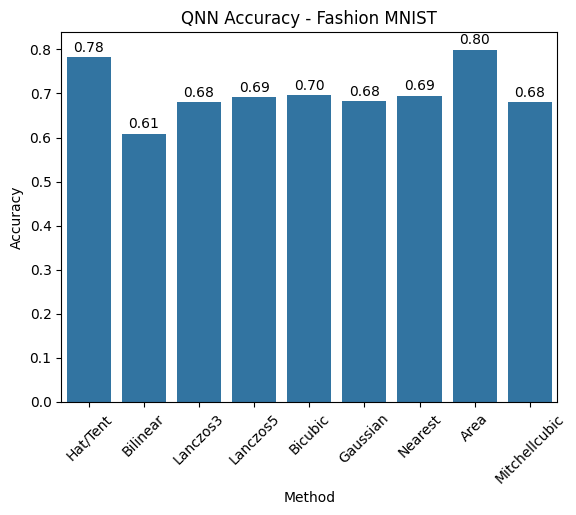

In [100]:
qnn_accuracy_hat_tent = qnn_results_hat_tent_fashion[1]
qnn_accuracy_bilinear = qnn_results_bilinear_cifar[1]
qnn_accuracy_lanczos3 = qnn_results_lanczos3_fashion[1]
qnn_accuracy_lanczos5 = qnn_results_lanczos5_fashion[1]
qnn_accuracy_bicubic = qnn_results_bicubic_fashion[1]
qnn_accuracy_gaussian = qnn_results_gaussian_fashion[1]
qnn_accuracy_nearest = qnn_results_nearest_fashion[1]
qnn_accuracy_area = qnn_results_area_fashion[1]
qnn_accuracy_mitchellcubic = qnn_results_mitchellcubic_fashion[1]

ax = sns.barplot(x=["Hat/Tent", "Bilinear", "Lanczos3", "Lanczos5", "Bicubic", "Gaussian", "Nearest", "Area", "Mitchellcubic"],
            y=[qnn_accuracy_hat_tent, qnn_accuracy_bilinear, qnn_accuracy_lanczos3, qnn_accuracy_lanczos5, qnn_accuracy_bicubic, qnn_accuracy_gaussian, qnn_accuracy_nearest, qnn_accuracy_area, qnn_accuracy_mitchellcubic])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('QNN Accuracy - Fashion MNIST')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Method')
# Imprima a acurácia acima de cada barra
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 7),
                textcoords = 'offset points')
plt.show()

# Comparação Filtros - Cifar 100

Number of original training examples: 50000
Number of original test examples: 10000
Shape of x_train: (1000, 32, 32, 1)


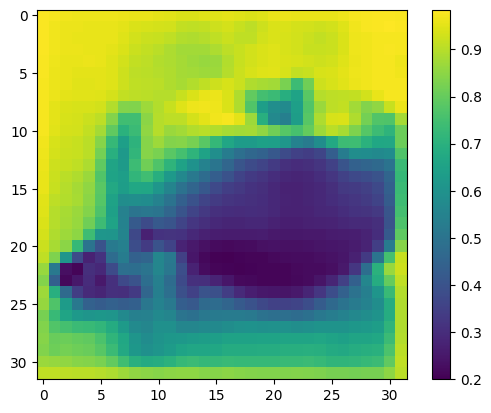

In [101]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

x_train = tf.image.rgb_to_grayscale(x_train).numpy()
x_test = tf.image.rgb_to_grayscale(x_test).numpy()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

class1 = 0  # Classe desejada 1
class2 = 1  # Classe desejada 2

# Filtrar os dados de treinamento
x_train = x_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]
y_train = y_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]

# Filtrar os dados de teste
x_test = x_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]
y_test = y_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]

# Normalizar as imagens para o intervalo [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# plot um exemplo
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

print("Shape of x_train:", x_train.shape)

## Filtro de interpolação bilinear

[0]
Epoch 1/3
32/32 [==============================] - 97s 3s/step - loss: 1.1271 - hinge_accuracy: 0.4268 - val_loss: 1.0833 - val_hinge_accuracy: 0.4241
Epoch 2/3
32/32 [==============================] - 97s 3s/step - loss: 0.9918 - hinge_accuracy: 0.5059 - val_loss: 0.9013 - val_hinge_accuracy: 0.5089
Epoch 3/3
7/7 [==============================] - 1s 162ms/step - loss: 0.8723 - hinge_accuracy: 0.5491


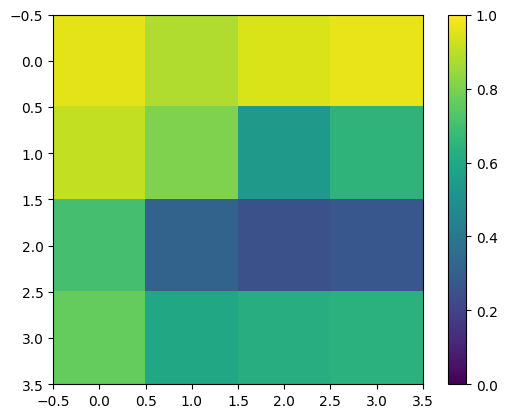

In [102]:
qnn_results_bilinear_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bilinear')

## Filtro Hat Tent

[0]
Epoch 1/3
32/32 [==============================] - 97s 3s/step - loss: 0.7666 - hinge_accuracy: 0.6543 - val_loss: 0.7186 - val_hinge_accuracy: 0.6920
Epoch 2/3
32/32 [==============================] - 97s 3s/step - loss: 0.7299 - hinge_accuracy: 0.6729 - val_loss: 0.6829 - val_hinge_accuracy: 0.7009
Epoch 3/3
7/7 [==============================] - 1s 163ms/step - loss: 0.6597 - hinge_accuracy: 0.7232


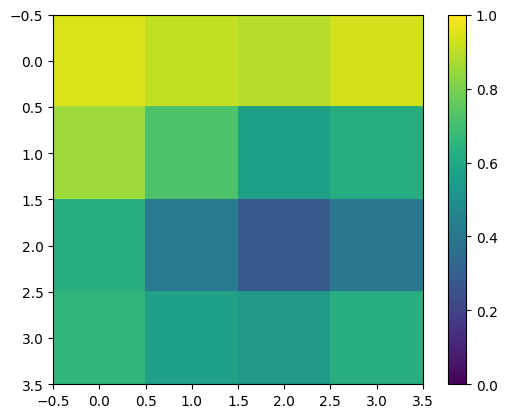

In [103]:
qnn_results_hat_tent_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bilinear', True)

## Filtro lanczos3

[0]
Epoch 1/3
32/32 [==============================] - 97s 3s/step - loss: 0.8279 - hinge_accuracy: 0.5967 - val_loss: 0.7853 - val_hinge_accuracy: 0.6071
Epoch 2/3
32/32 [==============================] - 97s 3s/step - loss: 0.8071 - hinge_accuracy: 0.6152 - val_loss: 0.7787 - val_hinge_accuracy: 0.6205
Epoch 3/3
7/7 [==============================] - 1s 168ms/step - loss: 0.7704 - hinge_accuracy: 0.6295


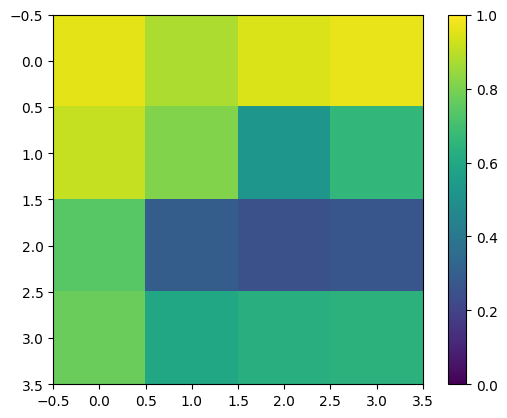

In [104]:
qnn_results_lanczos3_cifar100 = process_data(x_train, x_test, y_train, y_test, 'lanczos3')

## Filtro lanczos5

[0]
Epoch 1/3
32/32 [==============================] - 97s 3s/step - loss: 0.7780 - hinge_accuracy: 0.6523 - val_loss: 0.7646 - val_hinge_accuracy: 0.6429
Epoch 2/3
32/32 [==============================] - 97s 3s/step - loss: 0.7585 - hinge_accuracy: 0.6631 - val_loss: 0.7514 - val_hinge_accuracy: 0.6473
Epoch 3/3
7/7 [==============================] - 1s 165ms/step - loss: 0.7407 - hinge_accuracy: 0.6429


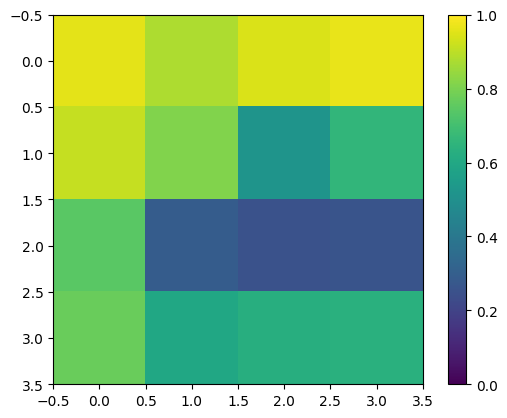

In [105]:
qnn_results_lanczos5_cifar100 = process_data(x_train, x_test, y_train, y_test, 'lanczos5')

## Filtro bicubic

[0]
Epoch 1/3
32/32 [==============================] - 97s 3s/step - loss: 0.7171 - hinge_accuracy: 0.6729 - val_loss: 0.7274 - val_hinge_accuracy: 0.6429
Epoch 2/3
32/32 [==============================] - 97s 3s/step - loss: 0.7007 - hinge_accuracy: 0.6846 - val_loss: 0.7137 - val_hinge_accuracy: 0.6652
Epoch 3/3
7/7 [==============================] - 1s 168ms/step - loss: 0.7021 - hinge_accuracy: 0.6696


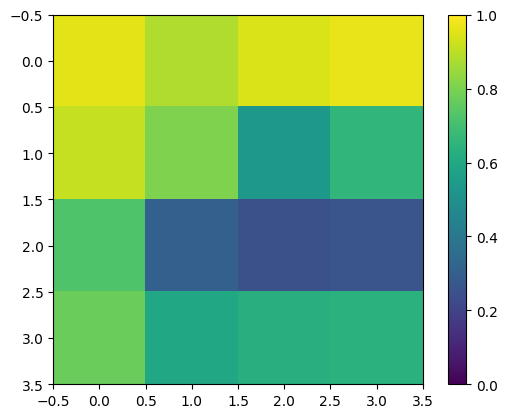

In [106]:
qnn_results_bicubic_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bicubic')

## Filtro gaussian

[0]
Epoch 1/3
32/32 [==============================] - 97s 3s/step - loss: 0.6682 - hinge_accuracy: 0.6934 - val_loss: 0.6510 - val_hinge_accuracy: 0.6786
Epoch 2/3
32/32 [==============================] - 97s 3s/step - loss: 0.6551 - hinge_accuracy: 0.6943 - val_loss: 0.6419 - val_hinge_accuracy: 0.6741
Epoch 3/3
7/7 [==============================] - 1s 161ms/step - loss: 0.6279 - hinge_accuracy: 0.6696


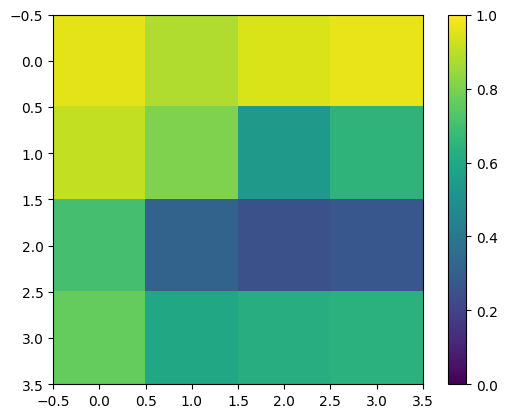

In [107]:
qnn_results_gaussian_cifar100 = process_data(x_train, x_test, y_train, y_test, 'gaussian')

## FIltro nearest

[0]
Epoch 1/3
32/32 [==============================] - 97s 3s/step - loss: 0.6629 - hinge_accuracy: 0.6992 - val_loss: 0.6601 - val_hinge_accuracy: 0.6429
Epoch 2/3
32/32 [==============================] - 97s 3s/step - loss: 0.6375 - hinge_accuracy: 0.7080 - val_loss: 0.6389 - val_hinge_accuracy: 0.6696
Epoch 3/3
7/7 [==============================] - 1s 167ms/step - loss: 0.6156 - hinge_accuracy: 0.6964


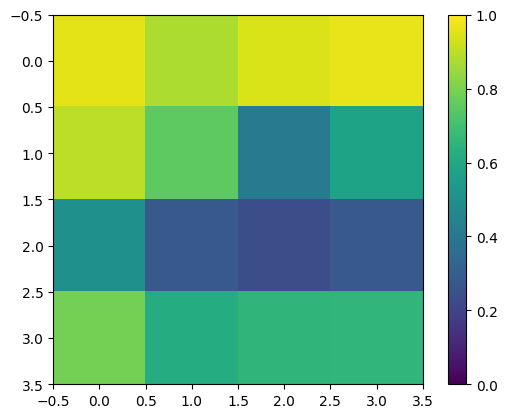

In [108]:
qnn_results_nearest_cifar100 = process_data(x_train, x_test, y_train, y_test, 'nearest')

## Filtro area

[0]
Epoch 1/3
32/32 [==============================] - 97s 3s/step - loss: 0.5806 - hinge_accuracy: 0.7217 - val_loss: 0.4906 - val_hinge_accuracy: 0.7768
Epoch 2/3
32/32 [==============================] - 97s 3s/step - loss: 0.5665 - hinge_accuracy: 0.7373 - val_loss: 0.4785 - val_hinge_accuracy: 0.7723
Epoch 3/3
7/7 [==============================] - 1s 170ms/step - loss: 0.4706 - hinge_accuracy: 0.7902


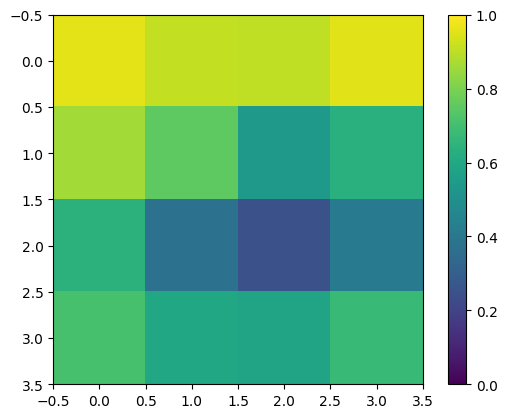

In [109]:
qnn_results_area_cifar100 = process_data(x_train, x_test, y_train, y_test, 'area')

## Fuiltro mitchellcubic

[0]
Epoch 1/3
32/32 [==============================] - 98s 3s/step - loss: 0.5651 - hinge_accuracy: 0.7432 - val_loss: 0.5564 - val_hinge_accuracy: 0.7634
Epoch 2/3
32/32 [==============================] - 97s 3s/step - loss: 0.5542 - hinge_accuracy: 0.7441 - val_loss: 0.5482 - val_hinge_accuracy: 0.7723
Epoch 3/3
7/7 [==============================] - 1s 167ms/step - loss: 0.5428 - hinge_accuracy: 0.7723


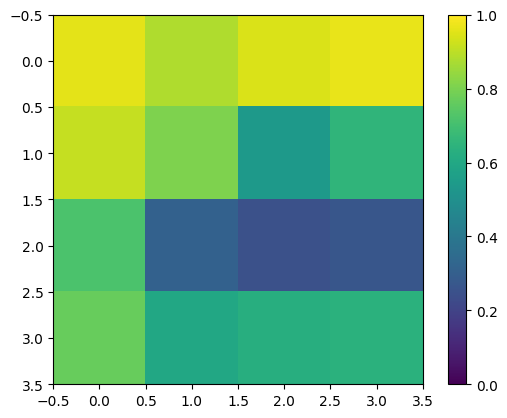

In [110]:
qnn_results_mitchellcubic_cifar100 = process_data(x_train, x_test, y_train, y_test, 'mitchellcubic')

## Comparação dos filtros

/tmp/ipykernel_6906/2989478445.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


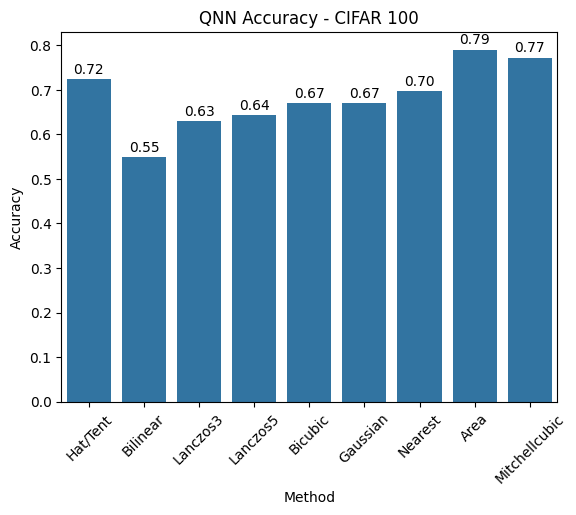

In [111]:
qnn_accuracy_hat_tent = qnn_results_hat_tent_cifar100[1]
qnn_accuracy_bilinear = qnn_results_bilinear_cifar100[1]
qnn_accuracy_lanczos3 = qnn_results_lanczos3_cifar100[1]
qnn_accuracy_lanczos5 = qnn_results_lanczos5_cifar100[1]
qnn_accuracy_bicubic = qnn_results_bicubic_cifar100[1]
qnn_accuracy_gaussian = qnn_results_gaussian_cifar100[1]
qnn_accuracy_nearest = qnn_results_nearest_cifar100[1]
qnn_accuracy_area = qnn_results_area_cifar100[1]
qnn_accuracy_mitchellcubic = qnn_results_mitchellcubic_cifar100[1]

ax = sns.barplot(x=["Hat/Tent", "Bilinear", "Lanczos3", "Lanczos5", "Bicubic", "Gaussian", "Nearest", "Area", "Mitchellcubic"],
            y=[qnn_accuracy_hat_tent, qnn_accuracy_bilinear, qnn_accuracy_lanczos3, qnn_accuracy_lanczos5, qnn_accuracy_bicubic, qnn_accuracy_gaussian, qnn_accuracy_nearest, qnn_accuracy_area, qnn_accuracy_mitchellcubic])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('QNN Accuracy - CIFAR 100')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Method')
# Imprima a acurácia acima de cada barra
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 7),
                textcoords = 'offset points')
plt.show()

# Comparação Filtros - ImageNet

  Obtaining dependency information for protobuf from https://files.pythonhosted.org/packages/5d/ae/3257b09328c0b4e59535e497b0c7537d4954038bdd53a2f0d2f49d15a7c4/protobuf-5.28.3-cp38-abi3-manylinux2014_x86_64.whl.metadata
  Using cached protobuf-5.28.3-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
Using cached protobuf-5.28.3-cp38-abi3-manylinux2014_x86_64.whl (316 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 5.28.3 which is incompatible.
tensorflow-quantum 0.7.2 requires protobuf==3.17.3, but you have protobuf 5.28.3 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[not

2024-11-15 23:05:33.727214: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2024-11-15 23:05:33.929489: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.
2024-11-15 23:05:34.250677: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 204800000 exceeds 10% of free system memory.
2024-11-15 23:05:34.521650: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 204800000 exceeds 10% of free system memory.


Number of original training examples: 50000
Number of original test examples: 10000
Shape of x_train: (10000, 32, 32, 1)


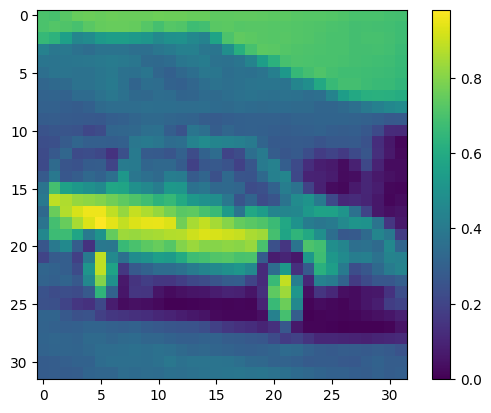

In [38]:
!pip install --upgrade protobuf
!pip install --upgrade tensorflow-datasets


import tensorflow_datasets as tfds

# Carregar o conjunto de dados COCO
dataset_name = "coco/2017"
dataset = tfds.load(dataset_name, split=tfds.Split.TRAIN)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = tf.image.rgb_to_grayscale(x_train).numpy()
x_test = tf.image.rgb_to_grayscale(x_test).numpy()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

class1 = 0  # Classe desejada 1
class2 = 1  # Classe desejada 2

# Filtrar os dados de treinamento
x_train = x_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]
y_train = y_train[(y_train[:, 0] == class1) | (y_train[:, 0] == class2)]

# Filtrar os dados de teste
x_test = x_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]
y_test = y_test[(y_test[:, 0] == class1) | (y_test[:, 0] == class2)]

# Normalizar as imagens para o intervalo [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# plot um exemplo
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

print("Shape of x_train:", x_train.shape)

In [43]:
dataset.train

AttributeError: 'PrefetchDataset' object has no attribute 'train'

## Filtro de interpolação bilinear

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 1.0075 - hinge_accuracy: 0.4902 - val_loss: 1.0519 - val_hinge_accuracy: 0.4777
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.9867 - hinge_accuracy: 0.5049 - val_loss: 1.0107 - val_hinge_accuracy: 0.5000
Epoch 3/3
7/7 [==============================] - 1s 62ms/step - loss: 0.9289 - hinge_accuracy: 0.5268


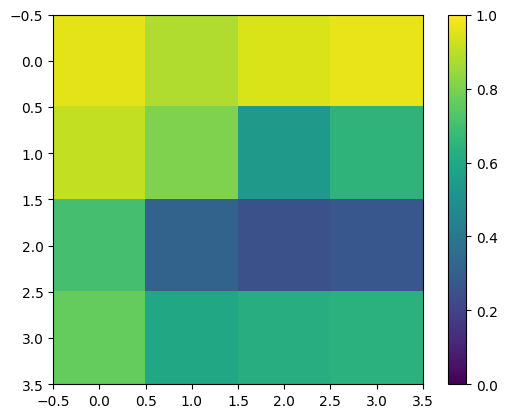

In [ ]:
qnn_results_bilinear_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bilinear')

## Filtro Hat Tent

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.9423 - hinge_accuracy: 0.5332 - val_loss: 0.9194 - val_hinge_accuracy: 0.5714
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8726 - hinge_accuracy: 0.5762 - val_loss: 0.8446 - val_hinge_accuracy: 0.6205
Epoch 3/3
7/7 [==============================] - 0s 61ms/step - loss: 0.8335 - hinge_accuracy: 0.6339


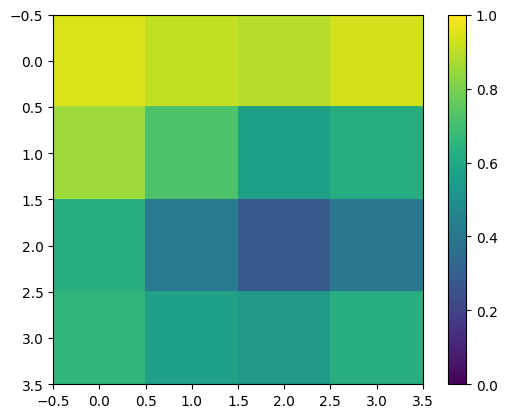

In [ ]:
qnn_results_hat_tent_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bilinear', True)

## Filtro lanczos3

[0]


Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8849 - hinge_accuracy: 0.5820 - val_loss: 0.8123 - val_hinge_accuracy: 0.6250
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8741 - hinge_accuracy: 0.5830 - val_loss: 0.7977 - val_hinge_accuracy: 0.6473
Epoch 3/3
7/7 [==============================] - 0s 62ms/step - loss: 0.7950 - hinge_accuracy: 0.6562


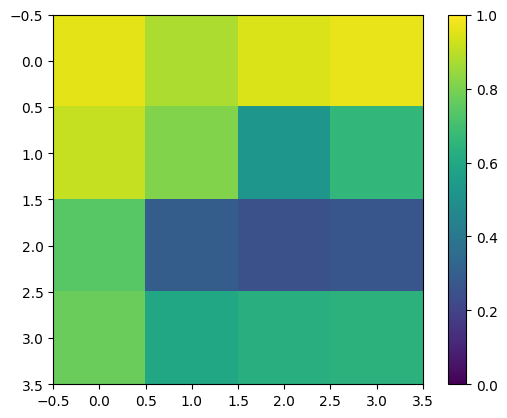

In [ ]:
qnn_results_lanczos3_cifar100 = process_data(x_train, x_test, y_train, y_test, 'lanczos3')

## Filtro lanczos5

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8523 - hinge_accuracy: 0.5879 - val_loss: 0.7930 - val_hinge_accuracy: 0.6295
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8498 - hinge_accuracy: 0.5928 - val_loss: 0.7882 - val_hinge_accuracy: 0.6295
Epoch 3/3
7/7 [==============================] - 0s 63ms/step - loss: 0.7802 - hinge_accuracy: 0.6250


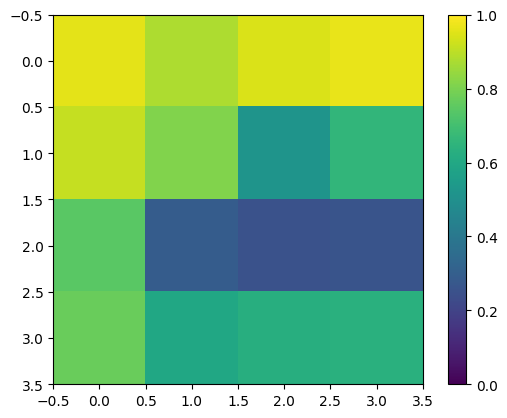

In [ ]:
qnn_results_lanczos5_cifar100 = process_data(x_train, x_test, y_train, y_test, 'lanczos5')

## Filtro bicubic

[0]


Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8508 - hinge_accuracy: 0.5898 - val_loss: 0.7529 - val_hinge_accuracy: 0.6429
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8473 - hinge_accuracy: 0.5889 - val_loss: 0.7511 - val_hinge_accuracy: 0.6429
Epoch 3/3
7/7 [==============================] - 0s 63ms/step - loss: 0.7499 - hinge_accuracy: 0.6384


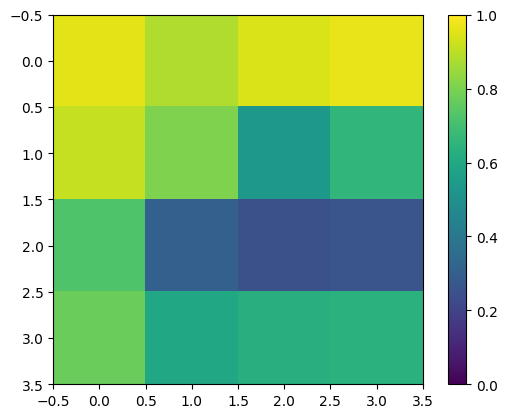

In [ ]:
qnn_results_bicubic_cifar100 = process_data(x_train, x_test, y_train, y_test, 'bicubic')

## Filtro gaussian

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8394 - hinge_accuracy: 0.5947 - val_loss: 0.7607 - val_hinge_accuracy: 0.6250
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8359 - hinge_accuracy: 0.5986 - val_loss: 0.7581 - val_hinge_accuracy: 0.6295
Epoch 3/3
7/7 [==============================] - 0s 61ms/step - loss: 0.7589 - hinge_accuracy: 0.6295


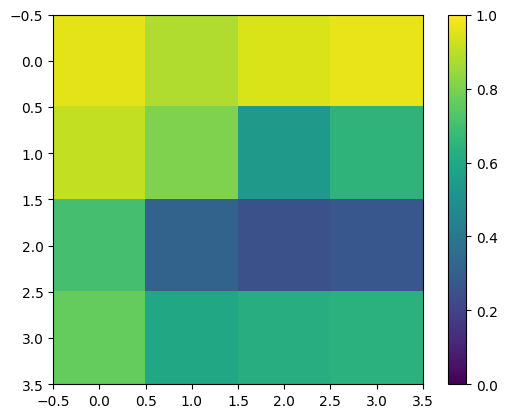

In [ ]:
qnn_results_gaussian_cifar100 = process_data(x_train, x_test, y_train, y_test, 'gaussian')

## FIltro nearest

[0]
Epoch 1/3
32/32 [==============================] - 35s 1s/step - loss: 0.8595 - hinge_accuracy: 0.5869 - val_loss: 0.8000 - val_hinge_accuracy: 0.6027
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8513 - hinge_accuracy: 0.5928 - val_loss: 0.7964 - val_hinge_accuracy: 0.6071
Epoch 3/3
7/7 [==============================] - 0s 62ms/step - loss: 0.7913 - hinge_accuracy: 0.6071


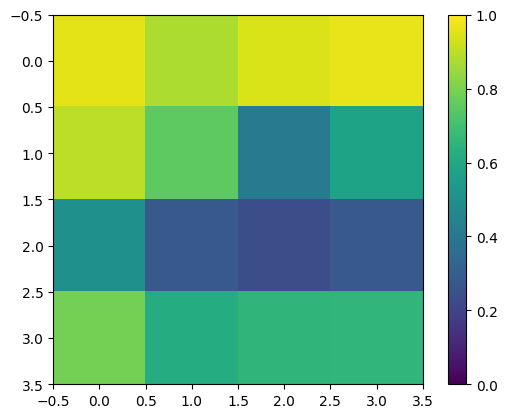

In [ ]:
qnn_results_nearest_cifar100 = process_data(x_train, x_test, y_train, y_test, 'nearest')

## Filtro area

[0]
Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8134 - hinge_accuracy: 0.6172 - val_loss: 0.7761 - val_hinge_accuracy: 0.6562
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.8117 - hinge_accuracy: 0.6104 - val_loss: 0.7703 - val_hinge_accuracy: 0.6562
Epoch 3/3
7/7 [==============================] - 0s 61ms/step - loss: 0.7686 - hinge_accuracy: 0.6562


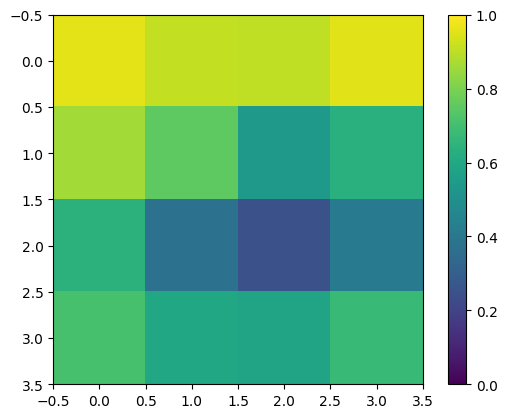

In [ ]:
qnn_results_area_cifar100 = process_data(x_train, x_test, y_train, y_test, 'area')

## Fuiltro mitchellcubic

[0]


Epoch 1/3
32/32 [==============================] - 34s 1s/step - loss: 0.8052 - hinge_accuracy: 0.6270 - val_loss: 0.7164 - val_hinge_accuracy: 0.6786
Epoch 2/3
32/32 [==============================] - 34s 1s/step - loss: 0.7973 - hinge_accuracy: 0.6250 - val_loss: 0.7120 - val_hinge_accuracy: 0.6786
Epoch 3/3
7/7 [==============================] - 0s 62ms/step - loss: 0.7150 - hinge_accuracy: 0.6741


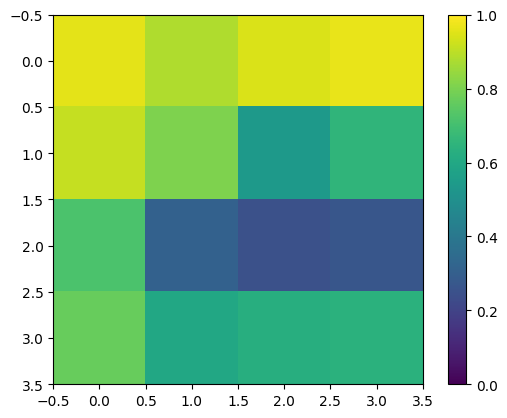

In [ ]:
qnn_results_mitchellcubic_cifar100 = process_data(x_train, x_test, y_train, y_test, 'mitchellcubic')

## Comparação dos filtros

/tmp/ipykernel_6169/2989478445.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


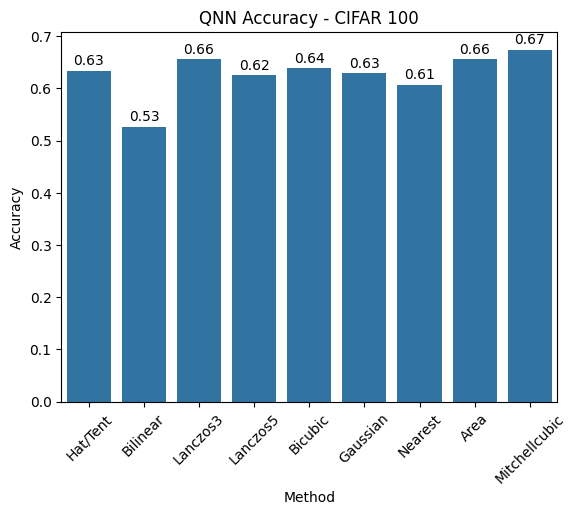

In [ ]:
qnn_accuracy_hat_tent = qnn_results_hat_tent_cifar100[1]
qnn_accuracy_bilinear = qnn_results_bilinear_cifar100[1]
qnn_accuracy_lanczos3 = qnn_results_lanczos3_cifar100[1]
qnn_accuracy_lanczos5 = qnn_results_lanczos5_cifar100[1]
qnn_accuracy_bicubic = qnn_results_bicubic_cifar100[1]
qnn_accuracy_gaussian = qnn_results_gaussian_cifar100[1]
qnn_accuracy_nearest = qnn_results_nearest_cifar100[1]
qnn_accuracy_area = qnn_results_area_cifar100[1]
qnn_accuracy_mitchellcubic = qnn_results_mitchellcubic_cifar100[1]

ax = sns.barplot(x=["Hat/Tent", "Bilinear", "Lanczos3", "Lanczos5", "Bicubic", "Gaussian", "Nearest", "Area", "Mitchellcubic"],
            y=[qnn_accuracy_hat_tent, qnn_accuracy_bilinear, qnn_accuracy_lanczos3, qnn_accuracy_lanczos5, qnn_accuracy_bicubic, qnn_accuracy_gaussian, qnn_accuracy_nearest, qnn_accuracy_area, qnn_accuracy_mitchellcubic])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('QNN Accuracy - CIFAR 100')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Method')
# Imprima a acurácia acima de cada barra
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 7),
                textcoords = 'offset points')
plt.show()